In [1]:
#%matplotlib inline
import argparse
import os
import random
import cv2
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
try: 
    from google.colab import files
    print("Running on Google Colab")
except ImportError: pass


# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [2]:
# Root directory for dataset
dataroot = "/Users/bastianchuttarsing/Downloads/logo_data"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 1000

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = torch.cuda.device_count()
print("Number of GPUs: ", ngpu)
n_critic = 5

lambda_gp = 5  # The lambda for the gradient penalty


Number of GPUs:  0


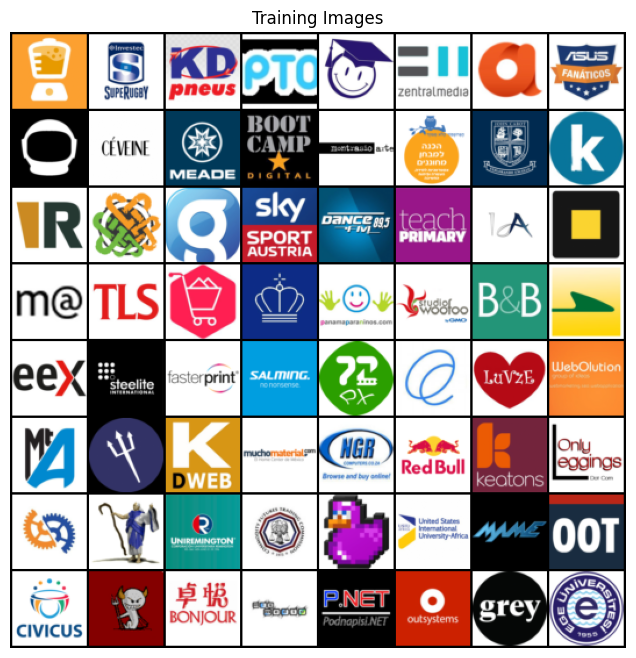

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# custom weights initialization called on ``netG`` and ``netC``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

**Conditional Generator**

In [5]:
print("nz: ", nz)
print("ngf: ", ngf)

nz:  100
ngf:  64


In [6]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

*test generator*

In [7]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


**Conditional Discriminator**

In [8]:
print("ndf", ndf)

ndf 64


In [9]:
class Critic(nn.Module):
    def __init__(self, ngpu):
        super(Critic, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            #nn.Sigmoid() # No sigmoid for iWGAN
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Create the Discriminator
netC = Critic(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netC = nn.DataParallel(netC, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netC.apply(weights_init)

# Print the model
print(netC)

Critic(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


### Loss Functions and Optimizers

In [11]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

In [12]:
def wasserstein_loss(y_real, y_fake):
    return torch.mean(y_fake - y_real)

def gradient_penalty(critic, real, fake, device="cpu"):
    alpha = torch.rand(real.shape[0], 1, 1, 1).to(device)
    interpolates = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    d_interpolates = critic(interpolates)
    gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates,
                                    grad_outputs=torch.ones(d_interpolates.size()).to(device),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
    return ((gradient_norm - 1) ** 2).mean()


In [15]:


#netG = Generator(ngpu).to(device)
#netC = Critic(ngpu).to(device)
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(beta1, 0.999))
optimizerC = optim.Adam(netC.parameters(), lr=0.0002, betas=(beta1, 0.999))



**Training**

In [ ]:
# Training Loop

# Lists to keep track of progress
gen_losses = []
critic_losses = []
wasserstein_distances = []
gradient_penalties = []
img_list=[]
iters = 0
print("Starting Training Loop...")
# Number of critic updates per generator update

# Training loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):

        # Move tensors to appropriate device
        real_images = real_images.to(device)

        # Critic update
        optimizerC.zero_grad()

        z = torch.randn(real_images.size(0),nz, 1,1).to(device)
        fake_images = netG(z)

        real_validity = netC(real_images)
        fake_validity = netC(fake_images.detach())

        loss_critic = wasserstein_loss(real_validity, fake_validity)

        # Compute Gradient Penalty
        gp = gradient_penalty(netC, real_images.data, fake_images.data, device=device)
        loss_critic += lambda_gp * gp

        loss_critic.backward()
        optimizerC.step()

        # Generator update
        if i % n_critic == 0:
            optimizerG.zero_grad()

            fake_images = netG(z)
            fake_validity = netC(fake_images)
            loss_gen = -torch.mean(fake_validity)
            gen_losses.append(loss_gen.item())

            loss_gen.backward()
            optimizerG.step()

        if i % 200 == 0:
                # Epoch-level logging
            print(f'Epoch [{epoch+1}/{num_epochs}] | '
                f'Gen Loss: {loss_gen.item():.4f} | '
                f'Critic Loss: {loss_critic.item():.4f} | '
                f'Wasserstein Distance: {-loss_critic.item():.4f} |'
                f'Gradient Penalty: {gp.item():.4f}')
            
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    iters += 1

    gen_losses.append(loss_gen.item())
    critic_losses.append(loss_critic.item())
    wasserstein_distances.append(-loss_critic.item())
    gradient_penalties.append(gp.item())

    s1 = pd.Series(gen_losses)
    s2 = pd.Series(critic_losses)
    s3 = pd.Series(wasserstein_distances)
    s4 = pd.Series(gradient_penalties)
    df = pd.DataFrame({'gen_losses': s1, 'critic_losses': s2, 'wasserstein_distances': s3, 'gradient_penalties': s4})


    df.to_csv('/content/drive/MyDrive/training_log3.csv', index=False)


    if ((epoch % 20 == 0 and epoch != 0)) or (epoch == num_epochs - 1):
        try:
            torch.save(netG.state_dict(), f"/content/drive/MyDrive/iWGAN_gen_model{3_epoch}.pth")
            torch.save(netC.state_dict(), f"/content/drive/MyDrive/iWGAN_cri_model{3_epoch}.pth")
        except: print("Drive not mounted")


**Results**

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses,label="G")
plt.plot(critic_losses,label="C")
plt.plot(wasserstein_distances,label="W")
plt.plot(gradient_penalties,label="GP")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real images vs Generated**

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [17]:
netG.load_state_dict(torch.load('/Users/bastianchuttarsing/Downloads/iWGAN_gen_model28.pth',map_location=torch.device('cpu')))
netC.load_state_dict(torch.load('/Users/bastianchuttarsing/Downloads/iWGAN_cri_model28.pth', map_location=torch.device('cpu')))


<All keys matched successfully>

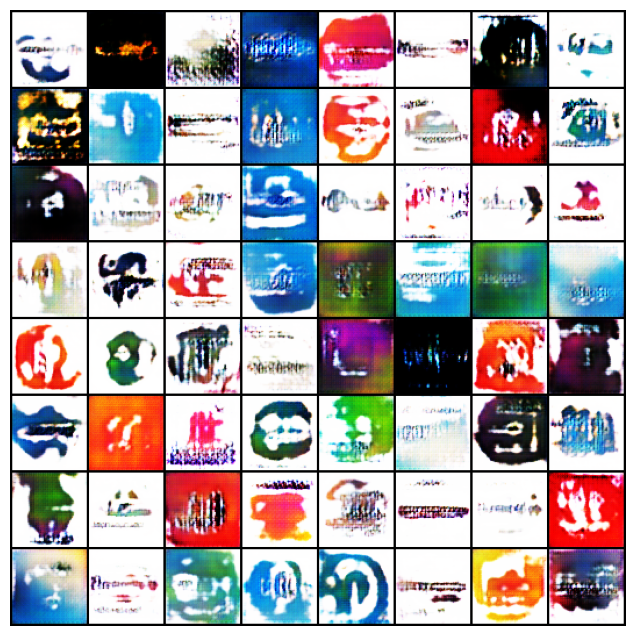

In [30]:
manualSeed = random.randint(1, 10000)
torch.manual_seed(manualSeed)
img_list =[]
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())